# Calculate Intersection Point

Ray equation
$$
\vec{p}(t) = \vec{p}_0 + t \hat{d}
$$
Plane equation uses three 3D coordinates for the triangle points $[x \; y \; z] \in \mathbf{R}^3$, and a normal direction $\hat{n}$ representing the outward face. 

Where $n_d$ is distance between $\vec{p}_0 = (a_1, b_1, c_1)$ any point on the plane along $\hat{n}$.
$$
\begin{aligned}
n_d &= \hat{n} \cdot (x_1 - a_1, y_1 - b_1, z_1 - c_1) \\
&= \hat{n} \cdot (x_2 - a_1, y_2 - b_1, z_2 - c_1) \\
&= \hat{n} \cdot (x_3 - a_1, y_3 - b_1, z_3 - c_1) \\
\end{aligned}
$$

The intersection distance $t$ from the ray origin is calculated, usually for several objects at once.
$$
t = \frac{n_d} {\hat{d} \cdot \hat{n}}
$$

Note if $\hat{d}$ and $\hat{n}$ are perpendicular, the dot product is zero and the plane is parallel to the ray. If $t < 0$ the intersection is behind the origin $\vec{p}_0$, and if $t = 0$ it's on the plane. If $t > 0$, check if the ray intersection is inside the triangle.

In [132]:
import numpy as np
from viewpoint_generation import load_mesh, TANK
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits import mplot3d

In [133]:
mesh, facets, unit_normals, mesh_centers, n = load_mesh(TANK)
# Create a dummy model
planes = np.array((
    [ # facet 1
        [0, 0, 0],
        [0, 1, 0],
        [0, 1, 1]
    ],
    [ # facet 2
        [2, 0, 0],
        [2, 1, 0],
        [2, 1, 1]
    ],
    [ # facet 3
        [-2, 0, 0],
        [-2, 1, 0],
        [-2, 1, 1]
    ],
    [ # facet 3
        [-3, 0, 0],
        [-3, 1, 0],
        [-3, 1, 1]
    ],
))

n = planes.shape[0]
norms = np.zeros((n, 3))
for i in range(n):
    e01 = planes[i,1] - planes[i,0]
    e02 = planes[i,2] - planes[i,0]
    norm = np.cross(e01, e02)
    norms[i] = norm / np.linalg.norm(norm)

norms


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [134]:
p_0 = np.array([1, .5, .5])
d = np.array([-1, 0, 0])

In [135]:
p = np.zeros((n, 3))
t = np.zeros(n)

for i in range(n):
    n_d = np.dot(planes[i, 0] - p_0, norms[i])
    t[i] = n_d / np.dot(d, norms[i])
    if t[i] > 0:  # only compute intersection if plane is in front of viewpoint
        p[i] = p_0 + t[i] * d
    else:
        print("Plane is not visible from this direction")
p

Plane is not visible from this direction


array([[ 0. ,  0.5,  0.5],
       [ 0. ,  0. ,  0. ],
       [-2. ,  0.5,  0.5],
       [-3. ,  0.5,  0.5]])

# Calculate Inside-Outside

Next calculate whether the intersected point $\vec{p}(t)$ lies within the triangle defined by $[v_1 \; v_2 \; v_3]^T$. The inside-outside test uses the cross product with the triangle edges to determine if the intersected point is inside or outside.

$$
\begin{aligned}
\hat{n} \cdot (v_1 - v_0) &\times (\vec{p}(t) - v_0) \geq 0\\
\hat{n} \cdot (v_2 - v_1) &\times (\vec{p}(t) - v_1) \geq 0\\
\hat{n} \cdot (v_0 - v_2) &\times (\vec{p}(t) - v_2) \geq 0\\

\end{aligned}
$$

In [136]:
p

array([[ 0. ,  0.5,  0.5],
       [ 0. ,  0. ,  0. ],
       [-2. ,  0.5,  0.5],
       [-3. ,  0.5,  0.5]])

In [137]:
# For a given direction, check if any plane is in front of the goal plane
goal_plane = 2  # this is the plane we're trying to see
t_goal = t[goal_plane]
for i in range(n):
    if (t[i] <= 0) or (t[i] > t_goal):
        continue  # skip points behind viewpoint or further than goal
    
    edges = np.array([planes[i,v1] - planes[i,v0] for v0, v1 in ((0,1), (1, 2), (2, 0))])
    C = p[i] - planes[i]
    result = np.array([np.dot(norms[i], np.cross(edges[j], C[j])) for j in range(3)])
    res = np.all(result >= 0)
    if res and t[i] < t_goal:
        print(f"Goal plane is blocked by plane {i}")
    # print("Edges:\n", edges)
    # print("Vertices to point C:\n",C)


Goal plane is blocked by plane 0


Point [0.  0.5 0.5] inside triangle: True


In [138]:
for j in range(3):
    res = np.cross(edges[j], C[j])
    print(res)

[0.5 0.  0. ]
[ 0.5  0.  -0. ]
[0. 0. 0.]


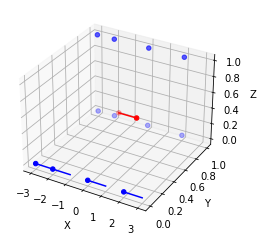

In [139]:
figure = plt.figure()
ax = figure.add_subplot(111, projection='3d')

for i in range(n):
    ax.scatter(
        planes[i, :, 0],
        planes[i, :, 1],
        planes[i, :, 2],
        c='b'
    )
    norm_p = planes[i, 0] + norms[i] 
    ax.plot(
        [planes[i, 0, 0], norm_p[0]],
        [planes[i, 0, 1], norm_p[1]],
        [planes[i, 0, 2], norm_p[2]],
        c='b'
    )

ax.scatter(
    [p_0[0], p[0,0]],
    [p_0[1], p[0,1]],
    [p_0[2], p[0,2]],
    c='r'
)
ax.plot(
    [p_0[0], p[0,0]],
    [p_0[1], p[0,1]],
    [p_0[2], p[0,2]],
    c='r'
)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [140]:
planes[i, :, 0]

array([-3, -3, -3])